### LLM Agent Collective Belief Formation Simulation
This notebook implements a simulation of LLM agents forming collective beliefs through conversations.

### Key Modifications:
1. **Asynchronous Parallel Processing**: Agents can have simultaneous conversations
2. **Prompt-based Belief Updates**: LLMs self-determine belief modifications
3. **Flexible Network Topology**: Support for random, fully connected, and custom networks

### Implementation Notes:
- The LLMInterface class provides a placeholder for LLM API integration
- Replace the `generate_response()` method with your preferred LLM API (OpenAI, Anthropic, etc.)
- The simulation runs without a real LLM API for testing purposes using mock responses

In [1]:
# Import required libraries
import os
import asyncio
import nest_asyncio
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any
import json
import logging
from dataclasses import dataclass, field
from enum import Enum
import time
from concurrent.futures import ThreadPoolExecutor
from openai import OpenAI
from openai import AsyncOpenAI
import re

# Apply nest_asyncio to allow async in Jupyter
nest_asyncio.apply()

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
nodesize = 200
agents = 100
steps = 30
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

### Network Topology Configuration

In [3]:
class NetworkType(Enum):
    """Enum for different network topology types"""
    LATTICE = "lattice"
    RANDOM = "random"
    FULLY_CONNECTED = "fully_connected"
    CUSTOM = "custom"
    SMALL_WORLD = "small_world"
    SCALE_FREE = "scale_free"

class NetworkTopology:
    """Class to handle different network topologies"""
    
    def __init__(self, network_type: NetworkType, num_agents: int, **kwargs):
        self.network_type = network_type
        self.num_agents = num_agents
        self.kwargs = kwargs
        self.graph = self._create_network()
    
    def _create_network(self) -> nx.Graph:
        """Create network based on specified type"""
        if self.network_type == NetworkType.LATTICE:
            # Create 2D lattice (grid)
            size = int(np.sqrt(self.num_agents))
            if size * size != self.num_agents:
                raise ValueError(f"For lattice network, num_agents must be a perfect square. Got {self.num_agents}")
            return nx.grid_2d_graph(size, size)
        
        elif self.network_type == NetworkType.RANDOM:
            # Create random network with specified edge probability
            edge_prob = self.kwargs.get('edge_probability', 0.3)
            return nx.erdos_renyi_graph(self.num_agents, edge_prob)
        
        elif self.network_type == NetworkType.FULLY_CONNECTED:
            # Create fully connected network
            return nx.complete_graph(self.num_agents)
        
        elif self.network_type == NetworkType.SMALL_WORLD:
            # Create small-world network (Watts-Strogatz)
            k = self.kwargs.get('k', 4)  # Each node connected to k nearest neighbors
            p = self.kwargs.get('p', 0.3)  # Rewiring probability
            return nx.watts_strogatz_graph(self.num_agents, k, p)
        
        elif self.network_type == NetworkType.SCALE_FREE:
            # Create scale-free network (Barabási-Albert)
            m = self.kwargs.get('m', 2)  # Number of edges to attach from new node
            return nx.barabasi_albert_graph(self.num_agents, m)
        
        elif self.network_type == NetworkType.CUSTOM:
            # Create custom network from provided adjacency matrix or edge list
            if 'adjacency_matrix' in self.kwargs:
                adj_matrix = self.kwargs['adjacency_matrix']
                return nx.from_numpy_array(adj_matrix)
            elif 'edge_list' in self.kwargs:
                G = nx.Graph()
                G.add_nodes_from(range(self.num_agents))
                G.add_edges_from(self.kwargs['edge_list'])
                return G
            else:
                raise ValueError("Custom network requires 'adjacency_matrix' or 'edge_list'")
        
        else:
            raise ValueError(f"Unknown network type: {self.network_type}")
    
    def get_neighbors(self, agent_id: int) -> List[int]:
        """Get list of neighbors for a specific agent"""
        if self.network_type == NetworkType.LATTICE:
            # Convert 2D position to 1D agent ID
            size = int(np.sqrt(self.num_agents))
            row, col = agent_id // size, agent_id % size
            neighbors = list(self.graph.neighbors((row, col)))
            # Convert back to 1D IDs
            return [n[0] * size + n[1] for n in neighbors]
        else:
            return list(self.graph.neighbors(agent_id))
    
    def visualize(self, agent_beliefs: Optional[Dict[int, float]] = None, ax=None, show=True):
        """Visualize the network topology"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
            created_figure = True
        else:
            created_figure = False
        
        # Set positions based on network type
        if self.network_type == NetworkType.LATTICE:
            size = int(np.sqrt(self.num_agents))
            pos = {}
            for i in range(self.num_agents):
                row, col = i // size, i % size
                pos[(row, col)] = (col, -row)
        else:
            pos = nx.spring_layout(self.graph, k=2, iterations=100)
        
        # Color nodes based on beliefs if provided
        if agent_beliefs:
            if self.network_type == NetworkType.LATTICE:
                # Convert beliefs dict to match lattice node format
                size = int(np.sqrt(self.num_agents))
                node_colors = []
                for node in self.graph.nodes():
                    agent_id = node[0] * size + node[1]
                    node_colors.append(agent_beliefs.get(agent_id, 0.0))
            else:
                node_colors = [agent_beliefs.get(i, 0.0) for i in self.graph.nodes()]
            
            # Draw network with colors
            nx.draw(self.graph, pos, node_color=node_colors, cmap='coolwarm', 
                    vmin=0, vmax=1, with_labels=True, node_size=nodesize, ax=ax)
            
            # Add colorbar only if we created our own figure
            if created_figure:
                sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=1))
                sm.set_array([])
                plt.colorbar(sm, label='Belief Value', ax=ax)
        else:
            nx.draw(self.graph, pos, with_labels=True, node_size=nodesize, ax=ax)
        
        ax.set_title(f"Network Topology: {self.network_type.value}")
        
        if created_figure and show:
            plt.show()

### LLM Interface Configuration

In [4]:
@dataclass
class LLMConfig:
    """Configuration for LLM API"""
    model_name: str = "gpt-4o-mini"  # Can be changed to any LLM
    temperature: float = 0.7
    max_tokens: int = 300
    api_key: Optional[str] = OPENAI_API_KEY
    api_base: Optional[str] = None

class LLMInterface:
    """Interface for LLM interactions with conversation context"""
    
    def __init__(self, llm_config):
        self.config = llm_config
        self.client = AsyncOpenAI(api_key=llm_config.api_key)
        self.model = llm_config.model_name
    
    async def generate_response(
        self, 
        prompt: str, 
        system_prompt: Optional[str] = None,
        conversation: Optional[List[Dict[str, str]]] = None,
        speaker_id: Optional[int] = None,
        other_id: Optional[int] = None
    ) -> str:
        """
        Generate response from LLM with conversation context
        
        Args:
            prompt: The current prompt/message to respond to
            system_prompt: System instruction for the LLM
            conversation: List of previous messages in the conversation
            speaker_id: ID of the current speaker (agent)
            other_id: ID of the other agent in the conversation
        """
        # Default system prompt
        if system_prompt is None:
            system_prompt = (
                f"You are Agent {speaker_id} engaged in a discussion. "
                "Respond thoughtfully based on the conversation history and your perspective."
            )
        
        messages = [{"role": "system", "content": system_prompt}]
        
        # Add conversation history from the current speaker's perspective
        if conversation:
            for msg in conversation:
                # Determine the speaker of the message
                if f"Agent {speaker_id}:" in msg.get("content", ""):
                    # Record own utterances as "assistant"
                    role = "assistant"
                    # Extract only content by removing agent ID
                    content = msg["content"].replace(f"Agent {speaker_id}: ", "")
                elif f"Agent {other_id}:" in msg.get("content", "") if other_id else True:
                    # Record other's utterances as "user"
                    role = "user"
                    # Extract only content by removing agent ID
                    content = msg["content"].replace(f"Agent {other_id}: ", "") if other_id else msg["content"]
                else:
                    # Use as is for other cases
                    role = msg.get("role", "user")
                    content = msg.get("content", "")
                
                messages.append({"role": role, "content": content})
        
        # Add current prompt
        messages.append({"role": "user", "content": prompt})
        
        try:
            response = await self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=self.config.temperature,
                max_tokens=self.config.max_tokens
            )
            return response.choices[0].message.content
        except Exception as e:
            # Error handling
            print(f"Error calling LLM API: {e}")
            # Fallback response
            return f"I understand your point about: {prompt[:50]}..."
    
    async def evaluate_belief_change(
        self, 
        current_belief: float, 
        conversation: List[Dict[str, str]], 
        topic: str,
        agent_id: int
    ) -> float:
        """
        Use LLM to evaluate how belief should change based on conversation
        
        Args:
            current_belief: Current belief level (-1 - 1)
            conversation: Full conversation history
            topic: Discussion topic
            agent_id: ID of the agent whose belief is being evaluated
        """
        # Convert conversation to string format
        conversation_text = "\n".join([msg["content"] for msg in conversation])
        
        prompt = f"""
            You are Agent {agent_id} with a current belief level of {current_belief:.2f} on a scale from -1 to 1 about the topic: "{topic}".

            You just had the following conversation:
            {conversation_text}

            Based on this conversation, evaluate how your belief should change. Consider:
            1. The strength and logic of arguments presented
            2. New information or perspectives shared
            3. How convincing the other agent's points were
            4. Whether your initial position was challenged effectively

            Respond with ONLY a number between -1 and 1 representing your new belief level.
            Do not include any explanation, just the number.
        """
        
        system_prompt = (
            "You are a rational agent who updates beliefs based on evidence and argumentation. "
            "Be open to changing your mind if presented with compelling arguments, "
            "but also maintain your position if the arguments are weak."
        )
        
        response = await self.generate_response(
            prompt=prompt,
            system_prompt=system_prompt,
            conversation=None  # Don't include conversation history during evaluation (already included in prompt)
        )
        
        # Extract number from response
        try:
            # Extract numbers
            numbers = re.findall(r'-?\d*\.?\d+', response)
            if numbers:
                new_belief = float(numbers[0])
                # Constrain belief value to [-1, 1] range
                return max(-1.0, min(1.0, new_belief))
        except:
            pass
        
        # Return small random change if parsing fails
        return current_belief + random.uniform(-0.1, 0.1)

### Agent Implementation with Asynchronous Conversations

In [5]:
class Agent:
    def __init__(self, agent_id, llm_interface=None, initial_belief=None):
        """Initialize an agent with LLM interface"""
        self.agent_id = agent_id
        self.llm_interface = llm_interface
        
        # Initialize belief randomly if not provided
        if initial_belief is None:
            self.belief = np.random.uniform(-1, 1)
        else:
            self.belief = initial_belief
            
        self.neighbors = []
        self.conversation_history = []
    
    def add_neighbor(self, neighbor):
        """Add a neighbor to this agent's network"""
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
    
    async def create_argument(self, topic):
        """Create an initial argument about the topic"""
        if not self.llm_interface:
            # Fallback if no LLM interface
            return f"I believe in this topic with strength {self.belief:.2f}."
        
        try:
            prompt = f"""
            Topic: {topic}
            Your current belief strength (-1 - 1): {self.belief:.2f}
            
            Create a brief argument that reflects your belief level about this topic.
            If belief is close to -1, be skeptical. If close to 1, be supportive.
            Keep it to 2-3 sentences.
            """
            
            response = await self.llm_interface.generate_response(
                prompt=prompt,
                system_prompt="You are an agent in a belief formation simulation."
            )
            
            return response
            
        except Exception as e:
            logger.error(f"Error creating argument for agent {self.agent_id}: {e}")
            return f"I believe the topic with strength {self.belief:.2f}."
    
    async def respond_to_argument(self, other_argument, topic, other_agent_id):
        """Respond to another agent's argument"""
        if not self.llm_interface:
            # Fallback if no LLM interface
            return f"I maintain my belief with strength {self.belief:.2f}."
        
        try:
            prompt = f"""
            Topic: {topic}
            Your current belief strength (-1 - 1): {self.belief:.2f}
            
            Agent {other_agent_id} said: {other_argument}
            
            Respond to their argument based on your belief level.
            If you agree, acknowledge it. If you disagree, counter it.
            Keep it to 2-3 sentences.
            """
            
            response = await self.llm_interface.generate_response(
                prompt=prompt,
                system_prompt="You are an agent in a belief formation simulation."
            )
            
            return response
            
        except Exception as e:
            logger.error(f"Error responding for agent {self.agent_id}: {e}")
            return f"I maintain my belief with strength {self.belief:.2f}."
    
    async def update_belief_after_conversation(self, conversation):
        """Update belief based on conversation"""
        if not self.llm_interface:
            # Simple rule-based update if no LLM
            change = np.clip(np.random.normal(0, 0.3), -1, 1) * 0.1
            self.belief = max(-1.0, min(1.0, self.belief + change))
            return
        
        try:
            prompt = f"""
            Your current belief strength (-1 - 1): {self.belief:.2f}
            
            Conversation you just had:
            {conversation}
            
            Based on this conversation, what should your new belief strength be?
            Return ONLY a number between -1 and 1.
            """
            
            response = await self.llm_interface.generate_response(
                prompt=prompt,
                system_prompt="You are an agent updating your belief. Return only a number between -1 and 1.",
            )
            
            try:
                new_belief = float(response.strip())
                self.belief = max(-1.0, min(1.0, new_belief))  # Clamp between -1 and 1
            except ValueError:
                logger.warning(f"Could not parse belief update for agent {self.agent_id}")
                
        except Exception as e:
            logger.error(f"Error updating belief for agent {self.agent_id}: {e}")

    async def choose_conversation_partner(self, available_neighbors: List['Agent'], topic: str) -> Optional[int]:
        """Choose a conversation partner from available neighbors using LLM"""
        if not self.llm_interface or not available_neighbors:
            return None
            
        try:
            neighbor_info = "\n".join([
                f"Agent {n.agent_id}: Current belief = {n.belief:.2f}"
                for n in available_neighbors
            ])
            
            prompt = f"""
            You are Agent {self.agent_id} with belief level {self.belief:.2f} about the topic: "{topic}".
            
            Available neighbors to converse with:
            {neighbor_info}
            
            Which agent would you like to have a conversation with? Consider:
            1. Agents with different beliefs might provide new perspectives
            2. Agents with similar beliefs might reinforce your views
            3. Your past conversations (if any) with these agents
            
            Respond with ONLY the agent ID number of your choice.
            """
            
            response = await self.llm_interface.generate_response(
                prompt=prompt,
                system_prompt="You are an agent choosing a conversation partner. Return only a number."
            )
            
            # Extract agent ID from response
            numbers = re.findall(r'\d+', response)
            if numbers:
                chosen_id = int(numbers[0])
                # Verify the chosen ID is valid
                if chosen_id in [n.agent_id for n in available_neighbors]:
                    return chosen_id
                    
        except Exception as e:
            logger.error(f"Error choosing partner for agent {self.agent_id}: {e}")
            
        return None

    async def negotiate_conversation(self, potential_partner: 'Agent', topic: str) -> bool:
        """Negotiate with another agent to agree on having a conversation"""
        if not self.llm_interface:
            return True  # Default to accepting if no LLM
            
        try:
            prompt = f"""
            You are Agent {self.agent_id} with belief level {self.belief:.2f} about the topic: "{topic}".
            Agent {potential_partner.agent_id} (belief level: {potential_partner.belief:.2f}) wants to have a conversation with you.
            
            Do you agree to have this conversation? Consider:
            1. Whether this conversation could be beneficial
            2. The other agent's belief level compared to yours
            3. Your interest in discussing with this particular agent
            
            Respond with ONLY "YES" or "NO".
            """
            
            response = await self.llm_interface.generate_response(
                prompt=prompt,
                system_prompt="You are an agent deciding whether to accept a conversation. Return only YES or NO."
            )
            
            return "YES" in response.upper()
            
        except Exception as e:
            logger.error(f"Error negotiating for agent {self.agent_id}: {e}")
            return True  # Default to accepting on error

    def record_conversation(self, other_agent_id: int, conversation: str) -> None:
        """Record conversation history"""
        if other_agent_id not in self.conversation_history:
            self.conversation_history[other_agent_id] = []
        
        # Parse conversation and save in message format
        for line in conversation.strip().split('\n'):
            if line.strip():
                self.conversation_history[other_agent_id].append({"content": line})

### Asynchronous Conversation Manager

In [6]:
class AsyncConversationManager:
    def __init__(self, topic, max_rounds=3, llm_config=None):
        self.topic = topic
        self.max_rounds = max_rounds
        self.llm_config = llm_config or LLMConfig()
        self.conversation_lock = asyncio.Lock()
        self.active_conversations = set()
    
    async def conduct_conversation(self, agent1, agent2):
        """Conduct a single conversation between two agents"""
        # Define conversation_id at the beginning
        conversation_id = (min(agent1.agent_id, agent2.agent_id), 
                          max(agent1.agent_id, agent2.agent_id))
        
        # Check if already conversing
        async with self.conversation_lock:
            if conversation_id in self.active_conversations:
                return None
            self.active_conversations.add(conversation_id)
        
        try:
            conversation_log = f"Conversation between Agent {agent1.agent_id} and Agent {agent2.agent_id}:\n"
            full_conversation = ""
            
            # Agent 1 starts
            arg1 = await agent1.create_argument(self.topic)
            conversation_log += f"Agent {agent1.agent_id}: {arg1}\n"
            full_conversation += f"Agent {agent1.agent_id}: {arg1}\n"
            
            # Agent 2 responds
            arg2 = await agent2.respond_to_argument(arg1, self.topic, agent1.agent_id)
            conversation_log += f"Agent {agent2.agent_id}: {arg2}\n"
            full_conversation += f"Agent {agent2.agent_id}: {arg2}\n"
            
            # Continue with rounds of responses
            for round in range(self.max_rounds - 1):
                # Agent 1 responds
                arg1 = await agent1.respond_to_argument(arg2, self.topic, agent2.agent_id)
                conversation_log += f"Agent {agent1.agent_id}: {arg1}\n"
                full_conversation += f"Agent {agent1.agent_id}: {arg1}\n"
                
                # Agent 2 responds
                arg2 = await agent2.respond_to_argument(arg1, self.topic, agent1.agent_id)
                conversation_log += f"Agent {agent2.agent_id}: {arg2}\n"
                full_conversation += f"Agent {agent2.agent_id}: {arg2}\n"
            
            # Update beliefs
            await agent1.update_belief_after_conversation(full_conversation)
            await agent2.update_belief_after_conversation(full_conversation)
            
            return conversation_log
            
        except Exception as e:
            logger.error(f"Error in conversation between {agent1.agent_id} and {agent2.agent_id}: {e}")
            return None
        finally:
            # Remove from active conversations
            async with self.conversation_lock:
                self.active_conversations.discard(conversation_id)
    
    async def parallel_conversations(self, conversation_pairs):
        """Conduct multiple conversations in parallel"""
        tasks = [
            self.conduct_conversation(agent1, agent2)
            for agent1, agent2 in conversation_pairs
        ]
        
        results = await asyncio.gather(*tasks)
        return [r for r in results if r]

### Simulation Controller

In [7]:
class BeliefFormationSimulation:
    """Main simulation controller for collective belief formation"""
    
    def __init__(self, 
                 num_agents: int,
                 topic: str,
                 network_type: NetworkType,
                 llm_config: Optional[LLMConfig] = None,
                 **network_kwargs):
        
        self.num_agents = num_agents
        self.topic = topic
        self.network = NetworkTopology(network_type, num_agents, **network_kwargs)
        
        # Initialize LLM interface
        self.llm_interface = LLMInterface(llm_config) if llm_config else None
        
        # Create agents
        self.agents = {
            i: Agent(agent_id=i, llm_interface=self.llm_interface)
            for i in range(num_agents)
        }
        
        # Conversation manager
        self.conversation_manager = AsyncConversationManager(topic)
        
        # Simulation history
        self.belief_history = [self.get_current_beliefs()]
        self.convergence_metrics = []
    
    def get_current_beliefs(self) -> Dict[int, float]:
        """Get current beliefs of all agents"""
        return {i: agent.belief for i, agent in self.agents.items()}
    
    def calculate_convergence_metric(self) -> float:
        """Calculate convergence metric (standard deviation of beliefs)"""
        beliefs = list(self.get_current_beliefs().values())
        return np.std(beliefs)
    
    async def get_autonomous_conversation_pairs(self, interaction_rate: float = 0.5) -> List[Tuple[Agent, Agent]]:
        """Get pairs of agents through autonomous LLM-based partner selection"""
        pairs = []
        conversing_agents = set()
        pending_requests = {}  # agent_id -> chosen_partner_id
        
        # Step 1: Each agent chooses who they want to talk to
        agent_choices = {}
        for agent_id, agent in self.agents.items():
            if random.random() > interaction_rate:
                continue
                
            neighbors = self.network.get_neighbors(agent_id)
            available_neighbors = [
                self.agents[n] for n in neighbors 
                if n not in conversing_agents
            ]
            
            if available_neighbors:
                chosen_partner_id = await agent.choose_conversation_partner(
                    available_neighbors, self.topic
                )
                if chosen_partner_id is not None:
                    agent_choices[agent_id] = chosen_partner_id
        
        # Step 2: Match agents who chose each other
        matched = set()
        for agent_id, chosen_id in agent_choices.items():
            if agent_id in matched or chosen_id in matched:
                continue
                
            # Check if there's mutual interest
            if chosen_id in agent_choices and agent_choices[chosen_id] == agent_id:
                # Mutual selection - create pair
                pairs.append((self.agents[agent_id], self.agents[chosen_id]))
                conversing_agents.update([agent_id, chosen_id])
                matched.update([agent_id, chosen_id])
        
        # Step 3: Handle unmatched agents through negotiation
        unmatched_agents = [
            agent_id for agent_id in agent_choices.keys() 
            if agent_id not in matched
        ]
        
        for agent_id in unmatched_agents:
            if agent_id in conversing_agents:
                continue
                
            chosen_id = agent_choices[agent_id]
            if chosen_id not in conversing_agents:
                # Ask the chosen agent if they want to converse
                agent_agrees = await self.agents[chosen_id].negotiate_conversation(
                    self.agents[agent_id], self.topic
                )
                
                if agent_agrees:
                    pairs.append((self.agents[agent_id], self.agents[chosen_id]))
                    conversing_agents.update([agent_id, chosen_id])
        
        return pairs
    
    def get_conversation_pairs(self, interaction_rate: float = 0.5) -> List[Tuple[Agent, Agent]]:
        """Get pairs of agents to converse based on network topology"""
        pairs = []
        conversing_agents = set()
        
        # Shuffle agent order for fairness
        agent_order = list(range(self.num_agents))
        random.shuffle(agent_order)
        
        for agent_id in agent_order:
            if agent_id in conversing_agents:
                continue
                
            if random.random() > interaction_rate:
                continue
            
            neighbors = self.network.get_neighbors(agent_id)
            available_neighbors = [n for n in neighbors if n not in conversing_agents]
            
            if available_neighbors:
                partner_id = random.choice(available_neighbors)
                pairs.append((self.agents[agent_id], self.agents[partner_id]))
                conversing_agents.add(agent_id)
                conversing_agents.add(partner_id)
        
        return pairs
    
    async def run_simulation_step(self, interaction_rate: float = 0.5, use_autonomous_pairing: bool = True) -> List[str]:
        """Run one step of the simulation with parallel conversations"""
        # Get conversation pairs
        if use_autonomous_pairing:
            pairs = await self.get_autonomous_conversation_pairs(interaction_rate)
        else:
            pairs = self.get_conversation_pairs(interaction_rate)
        
        # Conduct parallel conversations
        conversation_logs = await self.conversation_manager.parallel_conversations(pairs)
        
        # Update history
        self.belief_history.append(self.get_current_beliefs())
        self.convergence_metrics.append(self.calculate_convergence_metric())
        
        return conversation_logs
    
    async def run_full_simulation(self, 
                                 num_steps: int = 20,
                                 interaction_rate: float = 0.5,
                                 verbose: bool = True,
                                 use_autonomous_pairing: bool = True) -> Dict[str, Any]:
        """Run the full simulation for a specified number of steps"""
        
        logger.info(f"Starting simulation with {self.num_agents} agents on {self.network.network_type.value} network")
        logger.info(f"Topic: {self.topic}")
        logger.info(f"Using {'autonomous' if use_autonomous_pairing else 'random'} pairing")
        
        all_conversations = []
        
        for step in range(num_steps):
            if verbose:
                logger.info(f"\n=== Step {step + 1}/{num_steps} ===")
            
            # Run simulation step
            conversations = await self.run_simulation_step(interaction_rate, use_autonomous_pairing)
            all_conversations.extend(conversations)
            
            if verbose and conversations:
                logger.info(f"Conducted {len(conversations)} parallel conversations")
                logger.info(f"Convergence metric: {self.convergence_metrics[-1]:.4f}")
        
        # Compile results
        results = {
            'num_agents': self.num_agents,
            'topic': self.topic,
            'network_type': self.network.network_type.value,
            'num_steps': num_steps,
            'use_autonomous_pairing': use_autonomous_pairing,
            'belief_history': self.belief_history,
            'convergence_metrics': self.convergence_metrics,
            'final_beliefs': self.get_current_beliefs(),
            'total_conversations': len(all_conversations),
            'conversation_samples': all_conversations[:5] if verbose else []
        }
        
        return results
    
    def visualize_results(self):
        """Visualize simulation results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Network topology with final beliefs
        self.network.visualize(self.get_current_beliefs(), ax=axes[0, 0], show=False)
        
        # 2. Belief evolution over time
        ax = axes[0, 1]
        belief_matrix = np.array([list(beliefs.values()) for beliefs in self.belief_history]).T
        for i in range(self.num_agents):  # Show max 10 agents
            ax.plot(belief_matrix[i], alpha=0.7, label=f'Agent {i}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Belief Value')
        ax.set_title('Belief Evolution Over Time')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # 3. Convergence metric
        ax = axes[1, 0]
        ax.plot(self.convergence_metrics, 'b-', linewidth=2)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Belief Standard Deviation')
        ax.set_title('Convergence Metric Over Time')
        ax.grid(True, alpha=0.3)
        
        # 4. Final belief distribution
        ax = axes[1, 1]
        final_beliefs = list(self.get_current_beliefs().values())
        ax.hist(final_beliefs, bins=30, alpha=0.7, color='green', edgecolor='black')
        ax.set_xlabel('Belief Value')
        ax.set_ylabel('Number of Agents')
        ax.set_title('Final Belief Distribution')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

### Example Usage and Demonstrations

INFO:__main__:Starting simulation with 100 agents on fully_connected network
INFO:__main__:Topic: AI will significantly improve human life in the next decade
INFO:__main__:Using autonomous pairing
INFO:__main__:
=== Step 1/30 ===
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.

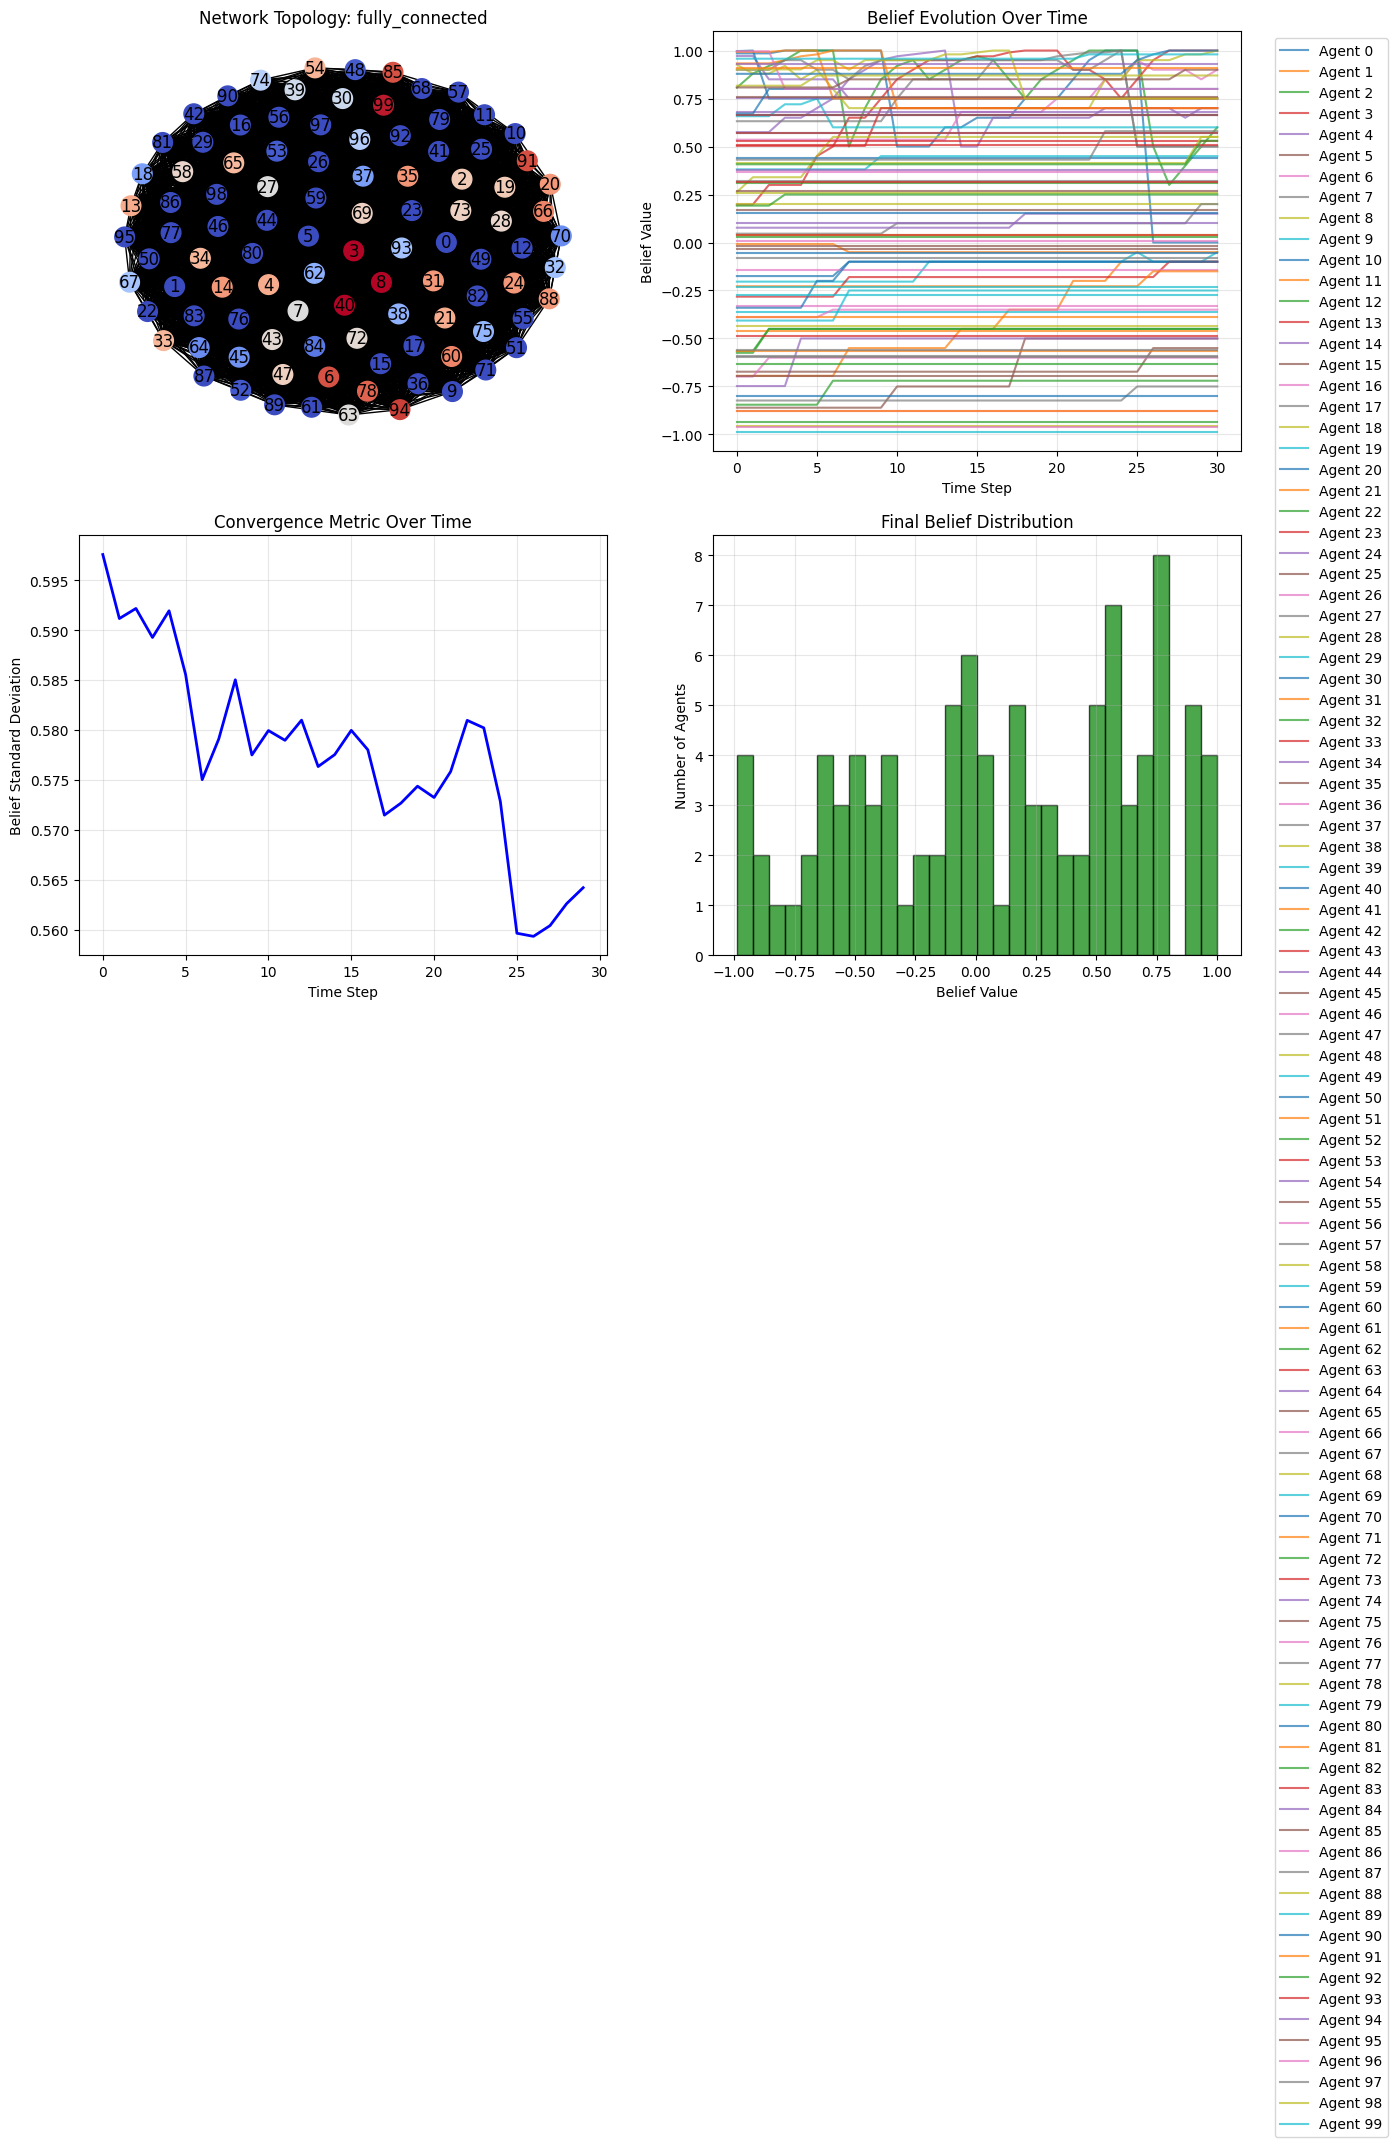

In [8]:
# Example 0: Fully Connected Network Simulation
async def run_fully_connected_network_example():
    """Example simulation with fully connected network"""
    
    # Configure simulation
    sim = BeliefFormationSimulation(
        num_agents=agents,
        topic="AI will significantly improve human life in the next decade",
        network_type=NetworkType.FULLY_CONNECTED,
        llm_config=LLMConfig(api_key=OPENAI_API_KEY)
    )
    
    # Run simulation
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.5,
        verbose=True
    )
    
    # Visualize results
    sim.visualize_results()
    
    return results

# Run the example
results = await run_fully_connected_network_example()

INFO:__main__:Starting simulation with 100 agents on random network
INFO:__main__:Topic: AI will significantly improve human life in the next decade
INFO:__main__:Using autonomous pairing
INFO:__main__:
=== Step 1/30 ===
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.co

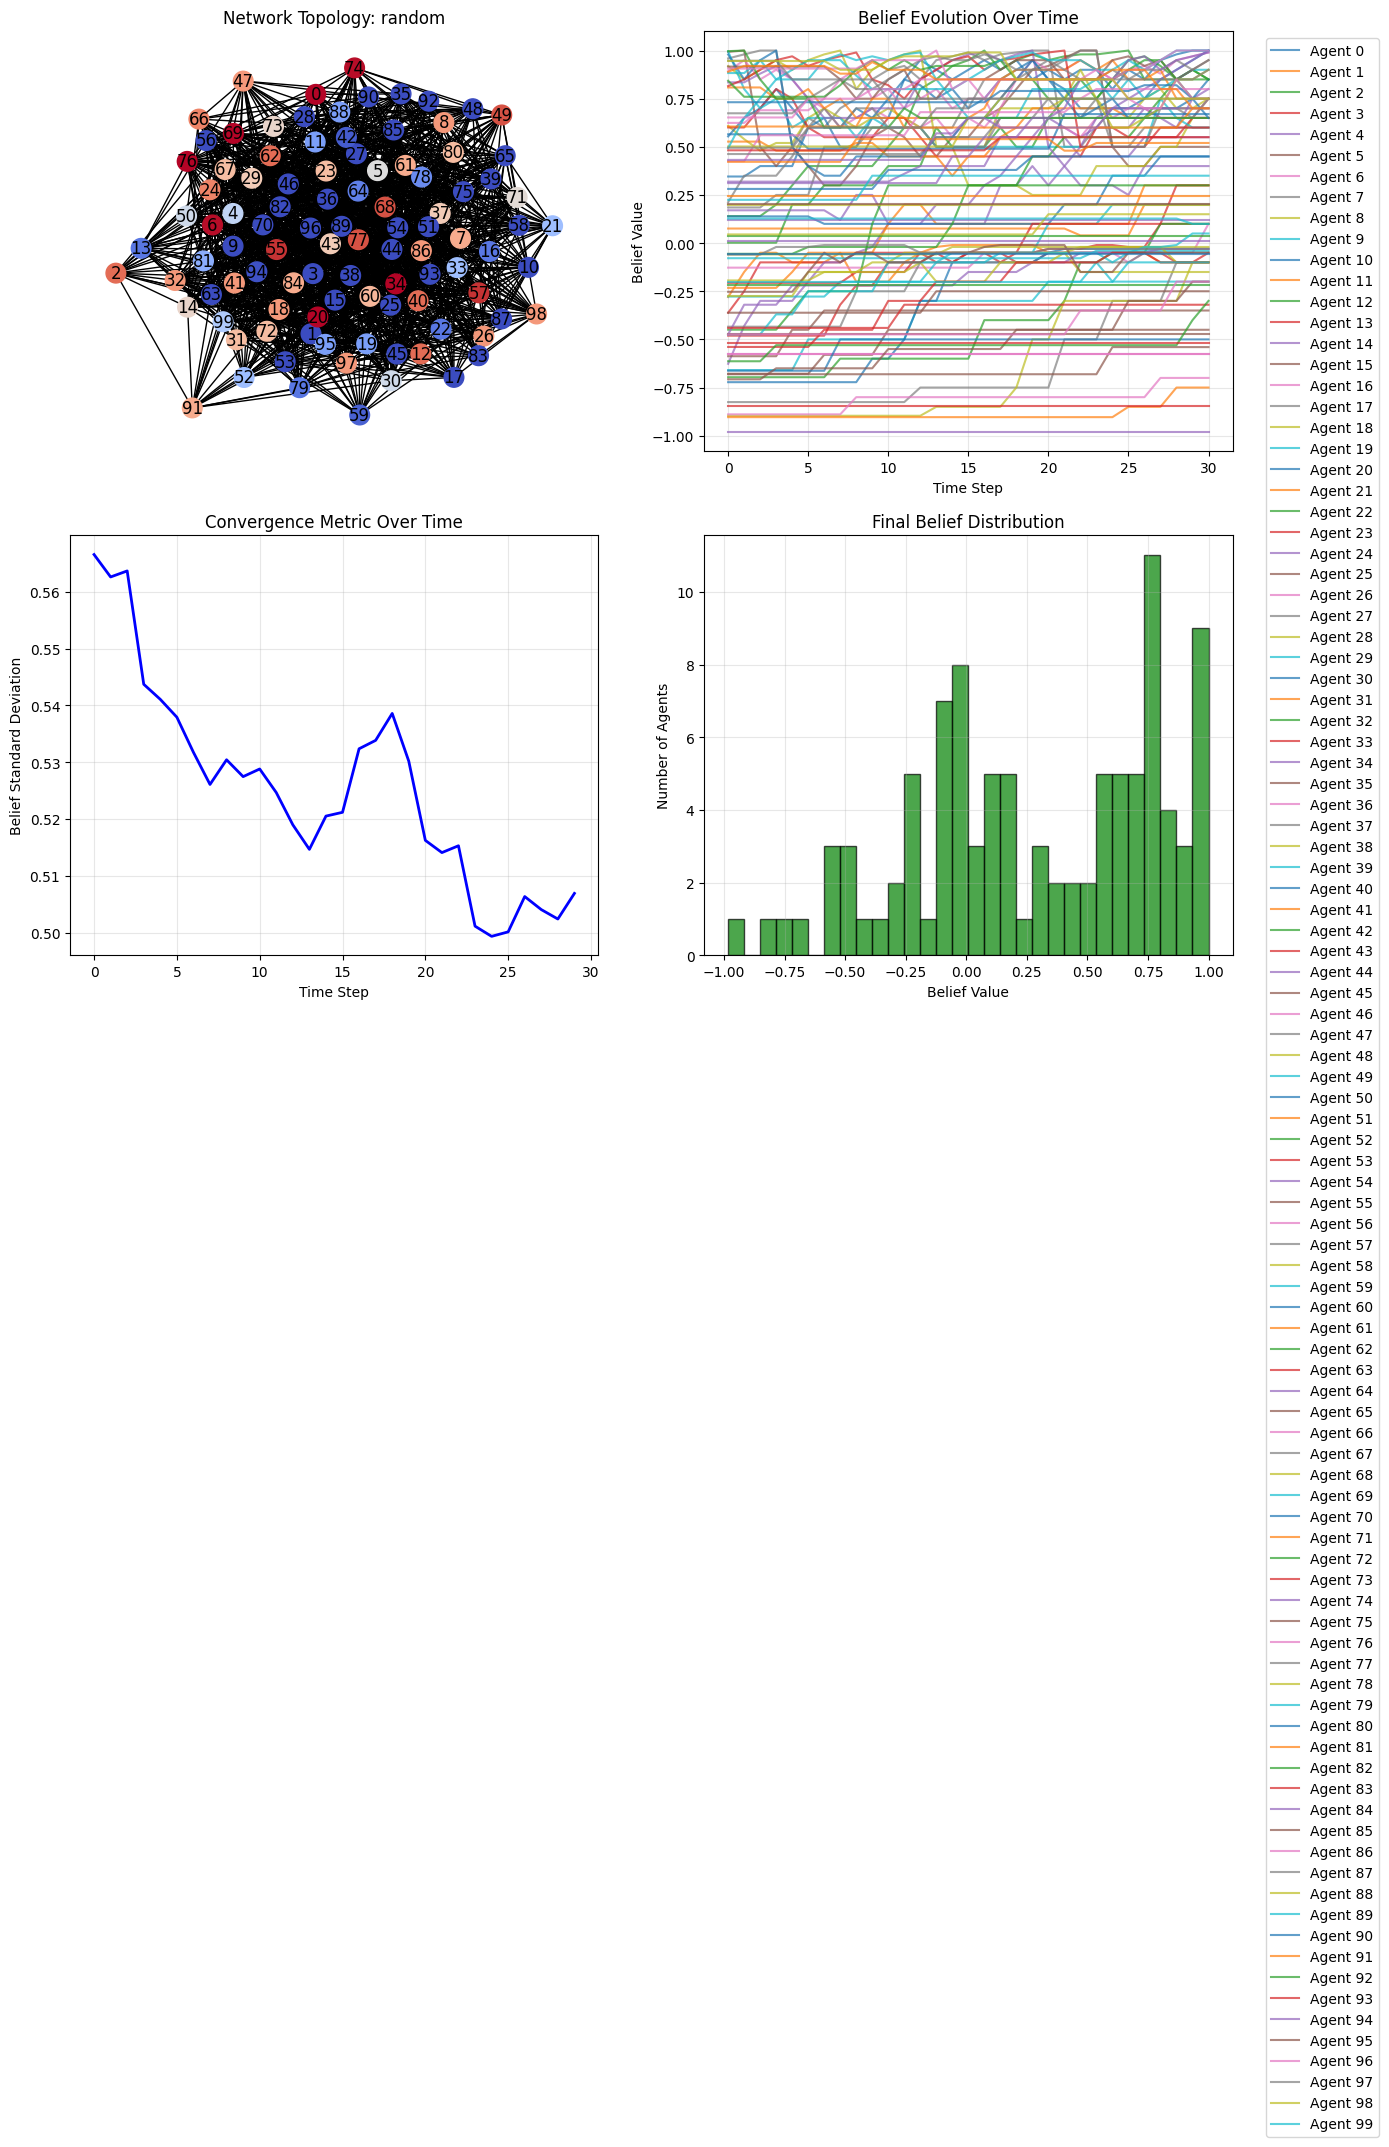

In [9]:
# Example 1: Random Network Simulation
async def run_random_network_example():
    """Example simulation with random network"""
    
    # Configure simulation
    sim = BeliefFormationSimulation(
        num_agents=agents,
        topic="AI will significantly improve human life in the next decade",
        network_type=NetworkType.RANDOM,
        edge_probability=0.3,
        llm_config=LLMConfig(api_key=OPENAI_API_KEY)
    )
    
    # Run simulation
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.5,
        verbose=True
    )
    
    # Visualize results
    sim.visualize_results()
    
    return results

# Run the example
results = await run_random_network_example()

INFO:__main__:Starting simulation with 100 agents on custom network
INFO:__main__:Topic: AI will significantly improve human life in the next decade
INFO:__main__:Using autonomous pairing
INFO:__main__:
=== Step 1/30 ===
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.co

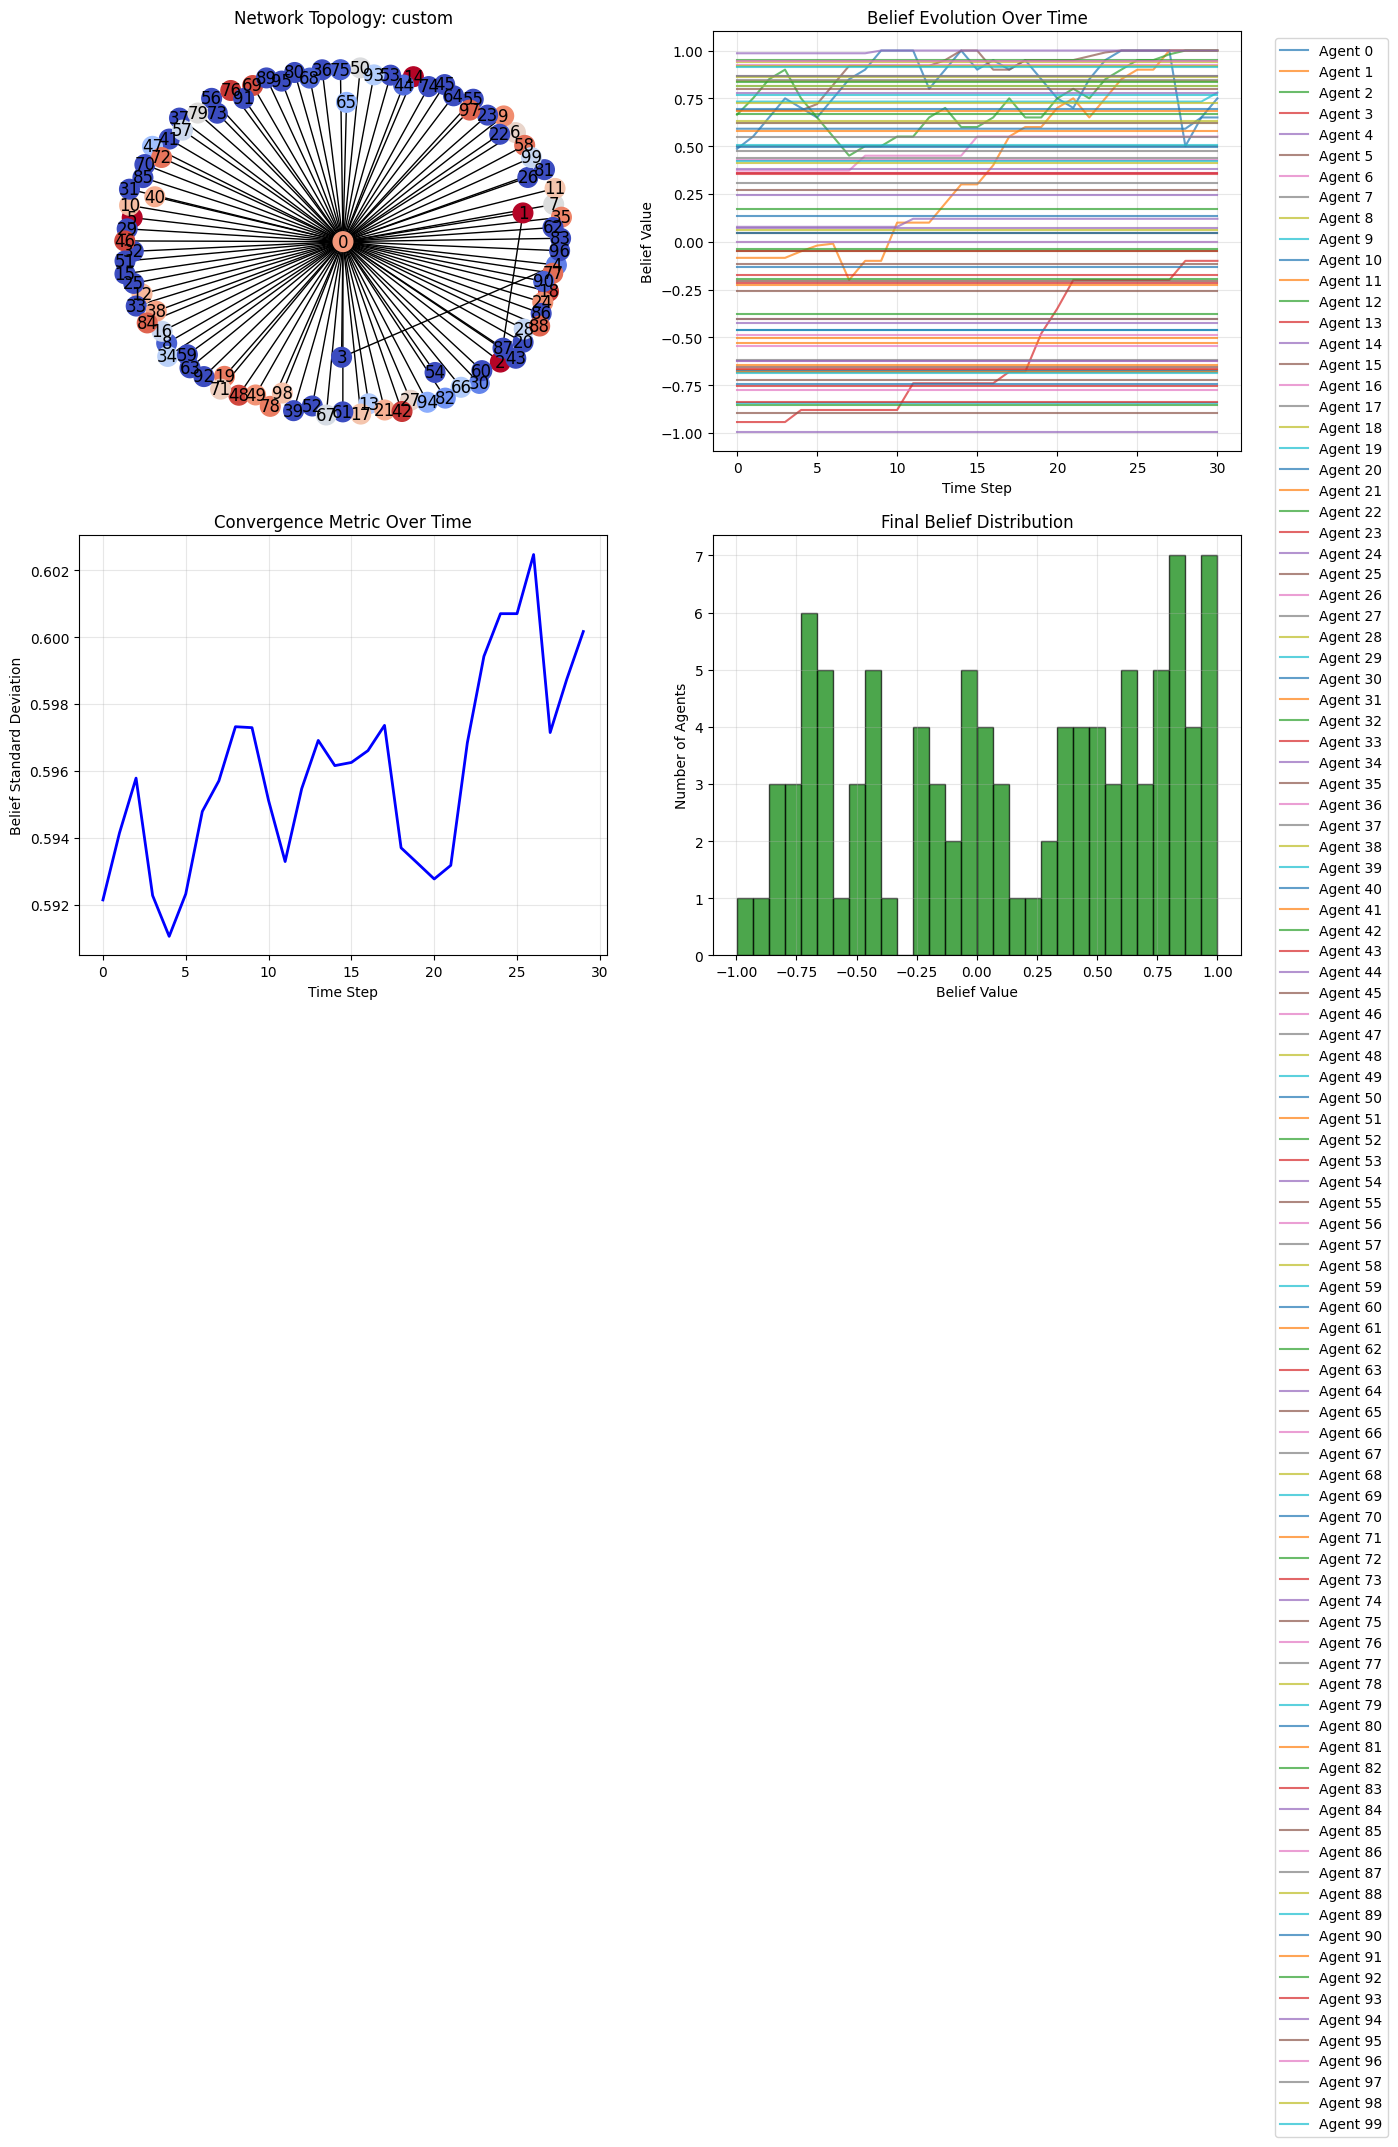

In [10]:
# Example 2: Custom Network from Adjacency Matrix
async def run_custom_network_example():
    """Example with custom network topology"""
    
    # Create a custom adjacency matrix (hub-and-spoke pattern)
    adj_matrix = np.zeros((agents, agents))
    
    # Create hub-and-spoke: agent 0 is connected to all others
    for i in range(1, agents):
        adj_matrix[0, i] = 1
        adj_matrix[i, 0] = 1
    
    # Add a few additional connections
    adj_matrix[1, 2] = adj_matrix[2, 1] = 1
    adj_matrix[3, 4] = adj_matrix[4, 3] = 1
    
    # Create simulation
    sim = BeliefFormationSimulation(
        num_agents=agents,
        topic="AI will significantly improve human life in the next decade",
        network_type=NetworkType.CUSTOM,
        adjacency_matrix=adj_matrix,
        llm_config=LLMConfig(api_key=OPENAI_API_KEY)
    )
    
    # Run simulation
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.7,
        verbose=True
    )
    
    # Show final results
    sim.visualize_results()
    
    return results

# Run the custom network example
custom_results = await run_custom_network_example()

INFO:__main__:Starting simulation with 100 agents on lattice network
INFO:__main__:Topic: AI will significantly improve human life in the next decade
INFO:__main__:Using autonomous pairing
INFO:__main__:
=== Step 1/30 ===
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.c

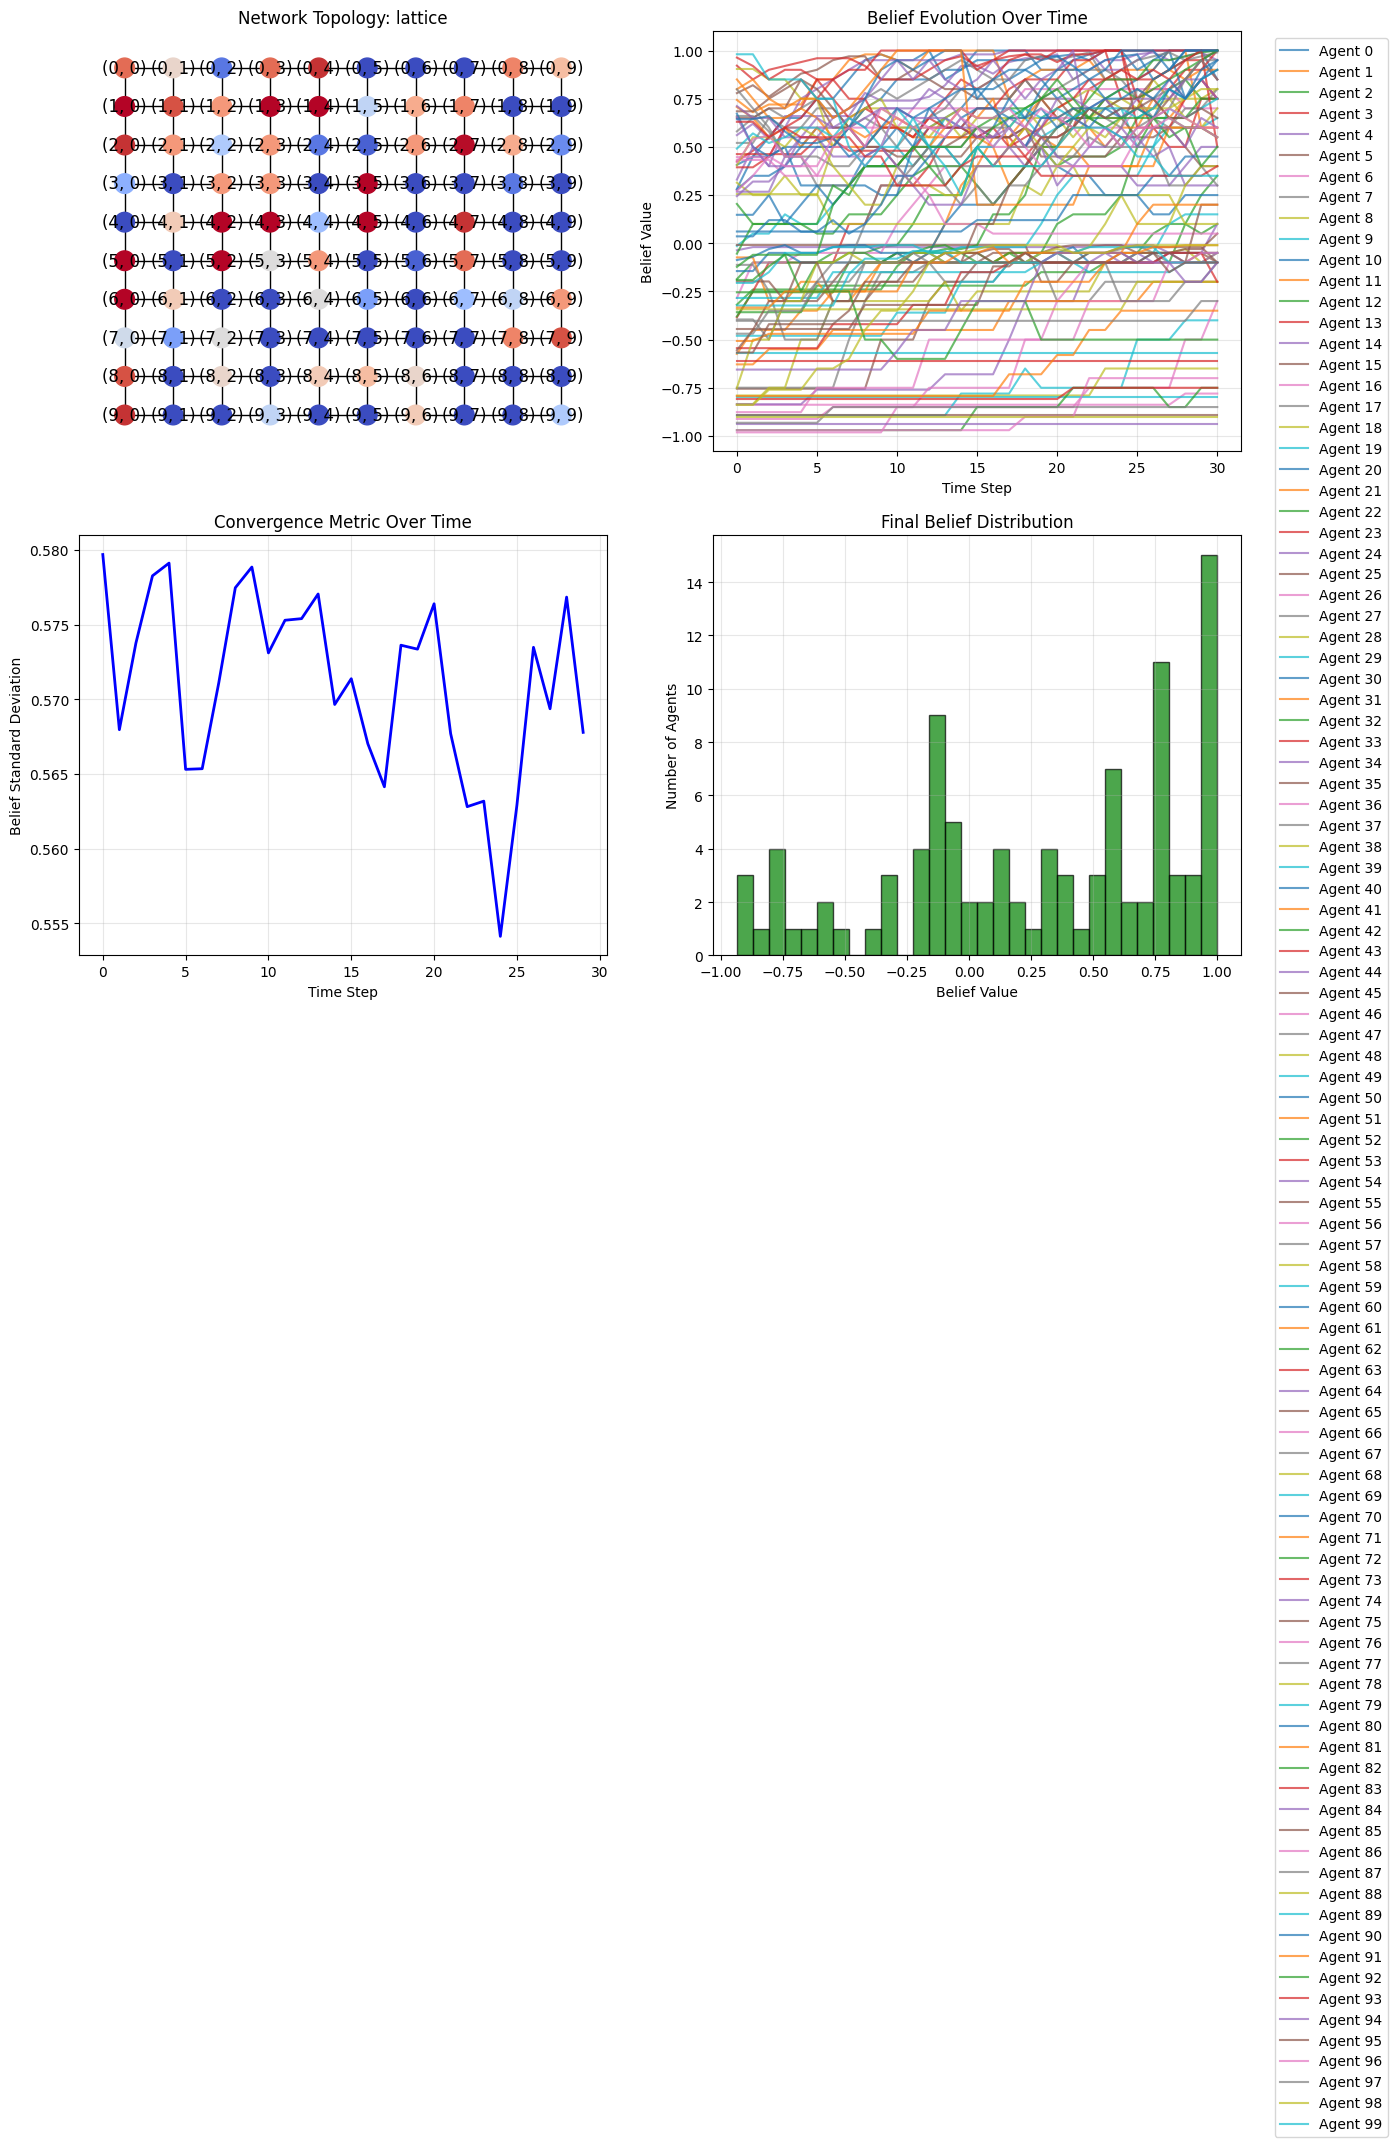


Simulation completed successfully!
Final convergence metric: 0.5678
Total conversations: 643


In [11]:
# Example 3: LATTICE Network Simulation
async def run_lattice_network_example():
    """Quick start example to test the simulation"""
    
    # Create a simple simulation
    sim = BeliefFormationSimulation(
        num_agents=agents,  # 10x10 grid for lattice
        topic="AI will significantly improve human life in the next decade",
        network_type=NetworkType.LATTICE,
        llm_config=LLMConfig(api_key=OPENAI_API_KEY)
    )
    
    # Run for just a few steps
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.5,
        verbose=True
    )
    
    # Visualize
    sim.visualize_results()
    
    print("\nSimulation completed successfully!")
    print(f"Final convergence metric: {results['convergence_metrics'][-1]:.4f}")
    print(f"Total conversations: {results['total_conversations']}")

# Uncomment to run:
await run_lattice_network_example()

INFO:__main__:Starting simulation with 100 agents on small_world network
INFO:__main__:Topic: AI will significantly improve human life in the next decade
INFO:__main__:Using autonomous pairing
INFO:__main__:
=== Step 1/30 ===
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.open

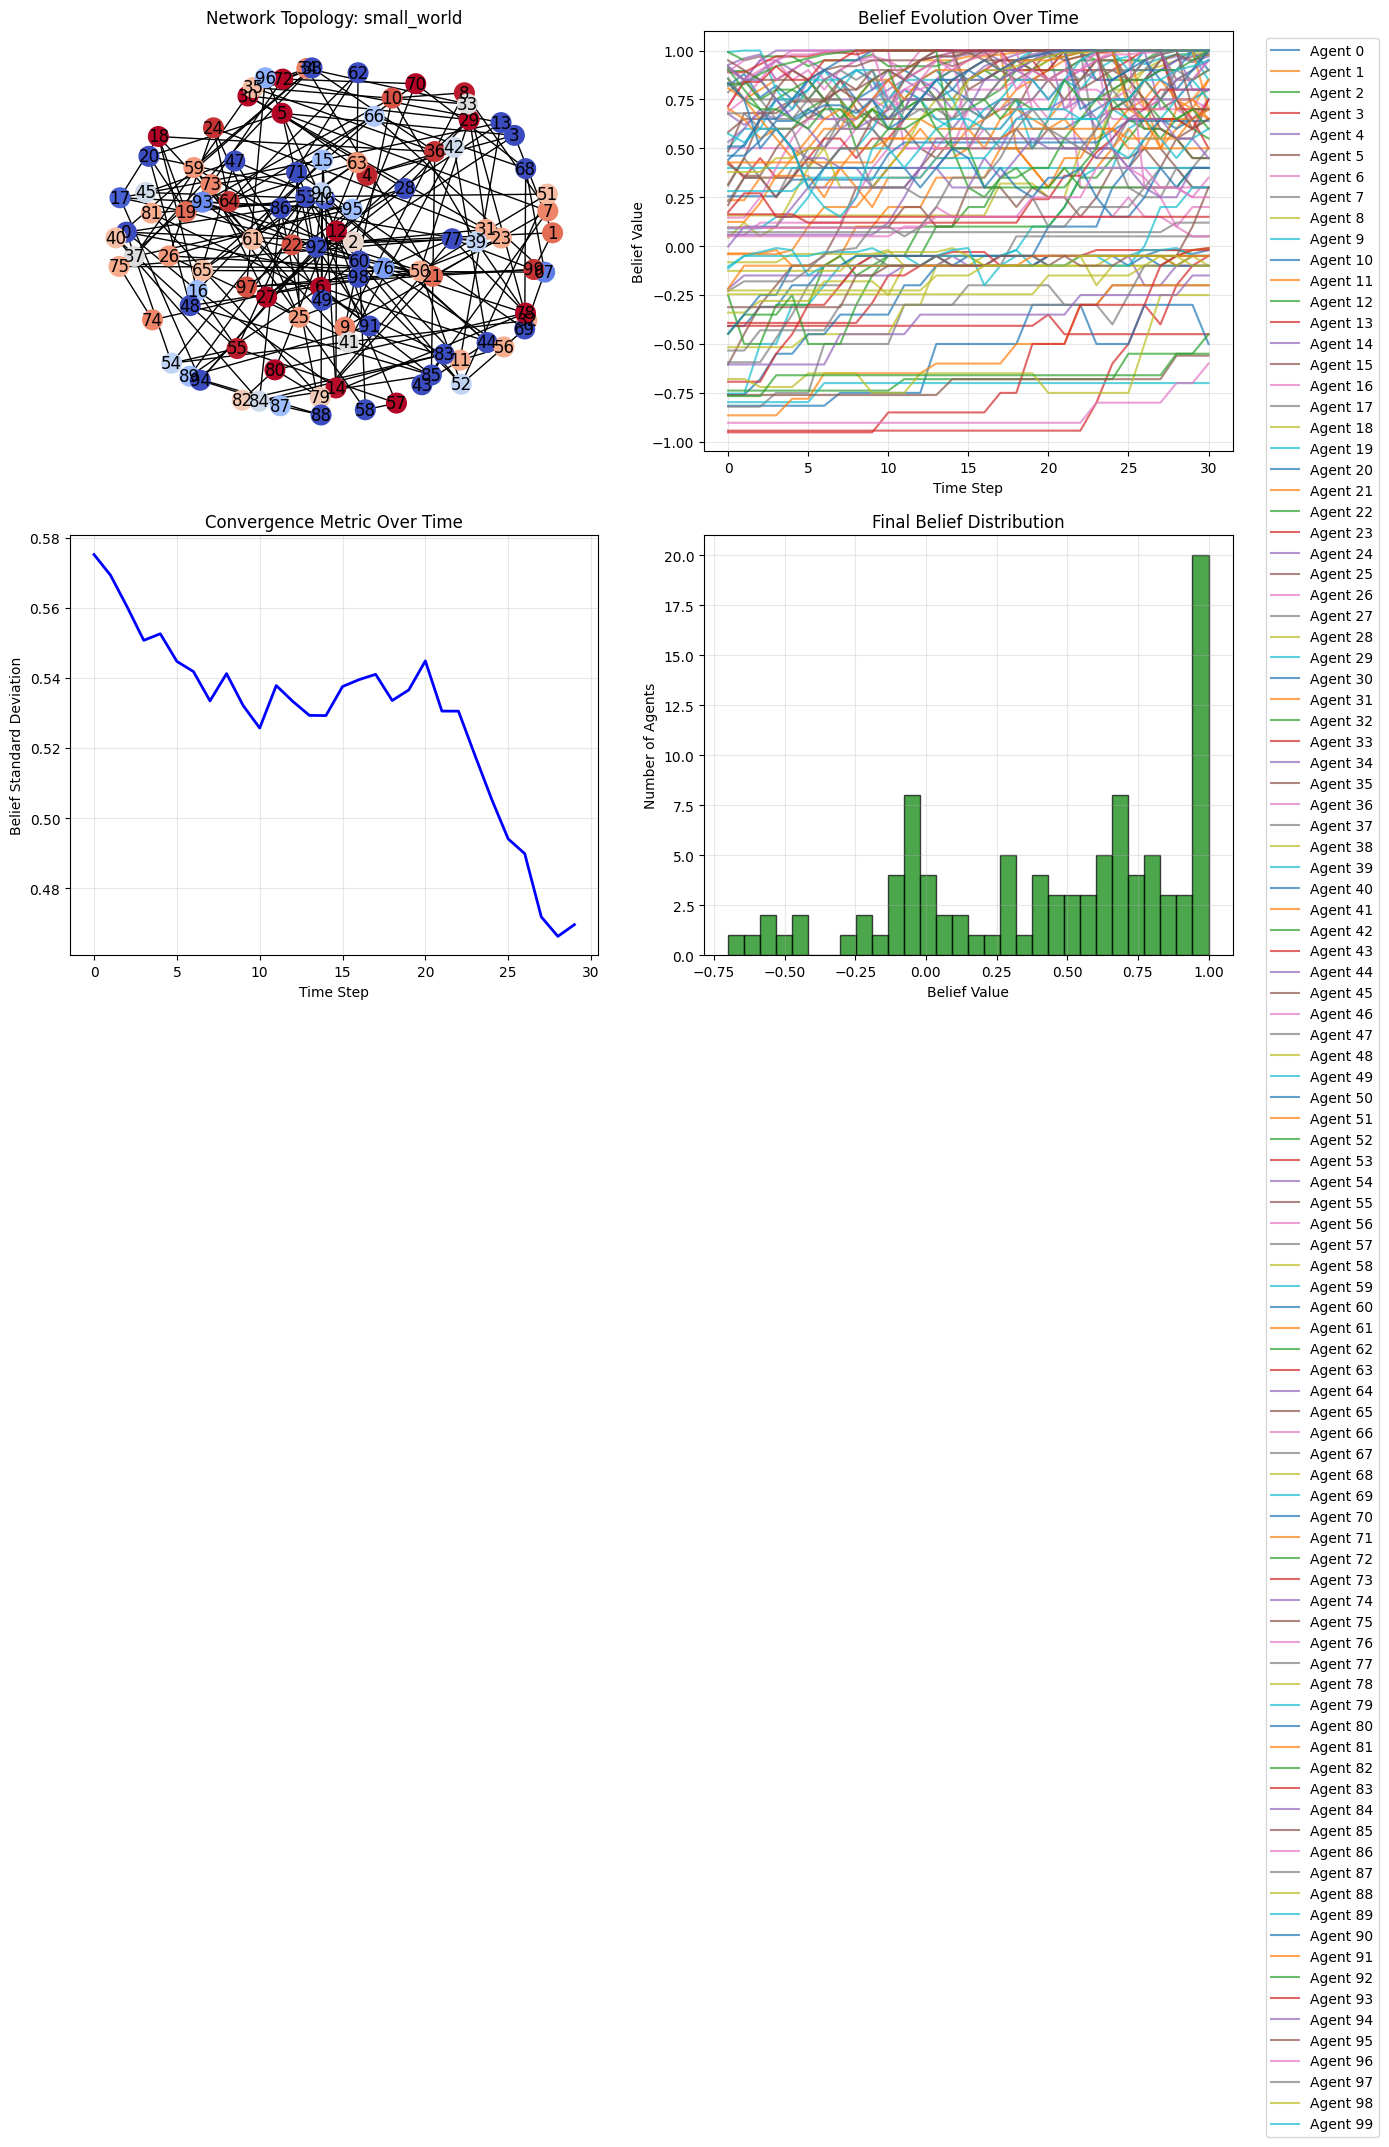


Simulation completed successfully!
Final convergence metric: 0.4697
Total conversations: 692


In [12]:
# Example 4: SMALL_WORLD Network Simulation
async def run_small_world_network_example():
    """Quick start example to test the simulation"""
    
    # Create a simple simulation
    sim = BeliefFormationSimulation(
        num_agents=agents,  # 10x10 grid for lattice
        topic="AI will significantly improve human life in the next decade",
        network_type=NetworkType.SMALL_WORLD,
        llm_config=LLMConfig(api_key=OPENAI_API_KEY)
    )
    
    # Run for just a few steps
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.5,
        verbose=True
    )
    
    # Visualize
    sim.visualize_results()
    
    print("\nSimulation completed successfully!")
    print(f"Final convergence metric: {results['convergence_metrics'][-1]:.4f}")
    print(f"Total conversations: {results['total_conversations']}")

# Uncomment to run:
await run_small_world_network_example()

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

INFO:__main__:

Running simulation for lattice network...
INFO:__main__:Starting simulation with 100 agents on lattice network
INFO:__main__:Topic: AI will significantly improve human life in the next decade
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/com

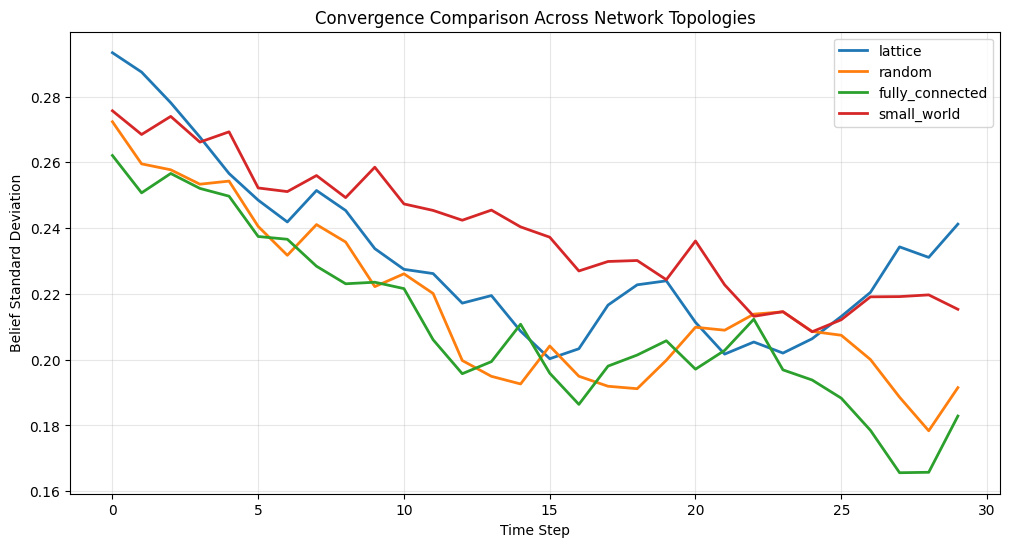


Summary of Results:
------------------------------------------------------------
Network Type         Final Std Dev   Final Mean Belief
------------------------------------------------------------
lattice              0.2412          0.3666         
random               0.1915          0.4225         
fully_connected      0.1829          0.3845         
small_world          0.2153          0.4635         


In [ ]:
# Example 4: Comparison of Different Network Topologies
async def compare_network_topologies():
    """Compare belief convergence across different network types"""
    
    network_configs = [
        (NetworkType.LATTICE, {}),
        (NetworkType.RANDOM, {'edge_probability': 0.3}),
        (NetworkType.FULLY_CONNECTED, {}),
        (NetworkType.SMALL_WORLD, {'k': 4, 'p': 0.3}),
    ]
    
    results_comparison = {}
    
    for network_type, kwargs in network_configs:
        logger.info(f"\n\nRunning simulation for {network_type.value} network...")
        
        sim = BeliefFormationSimulation(
            num_agents=agents,
            topic="AI will significantly improve human life in the next decade",
            network_type=network_type,
            **kwargs,
            llm_config=LLMConfig(api_key=OPENAI_API_KEY)
        )
        
        results = await sim.run_full_simulation(
            num_steps=steps,
            interaction_rate=0.5,
            verbose=False
        )
        
        results_comparison[network_type.value] = {
            'convergence_metrics': results['convergence_metrics'],
            'final_std': results['convergence_metrics'][-1],
            'final_mean_belief': np.mean(list(results['final_beliefs'].values()))
        }
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    for network_name, data in results_comparison.items():
        plt.plot(data['convergence_metrics'], label=network_name, linewidth=2)
    
    plt.xlabel('Time Step')
    plt.ylabel('Belief Standard Deviation')
    plt.title('Convergence Comparison Across Network Topologies')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print summary
    print("\nSummary of Results:")
    print("-" * 60)
    print(f"{'Network Type':<20} {'Final Std Dev':<15} {'Final Mean Belief':<15}")
    print("-" * 60)
    for network_name, data in results_comparison.items():
        print(f"{network_name:<20} {data['final_std']:<15.4f} {data['final_mean_belief']:<15.4f}")
    
    return results_comparison

# Run the comparison
comparison_results = await compare_network_topologies()

### Running the Simulation

To run the simulation with your own LLM:

1. Implement the `LLMInterface.generate_response()` method with your preferred LLM API
2. Configure the `LLMConfig` with your API credentials
3. Run any of the example simulations

The simulation supports:
- **Asynchronous conversations**: Multiple agent pairs can converse simultaneously
- **Prompt-based belief updates**: LLMs determine their own belief changes
- **Flexible network topologies**: Choose from lattice, random, fully connected, small-world, scale-free, or custom networks